## Скачивание файлов, деление на фолды

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math
from tqdm.notebook import tqdm

URL = 'https://storage.googleapis.com/oleg-zyablov/misc/VoiceMOS'
!wget -q {URL}/data.csv

data = pd.read_csv('data.csv')
data = data[data.subset.isin(['train', 'val']) & data.file_exists]
#data = data[data.subset.isin(['train']) & data.file_exists] #TODO заменить

n_folds = 5
fold_size = math.ceil(len(data) / n_folds)
cumsum = data.groupby('system').file.count().cumsum()
system_to_fold = {}
for i in range(n_folds):
  systems = cumsum[(cumsum > fold_size*i) & (cumsum <= fold_size*(i+1))].index.tolist()
  for s in systems:
    system_to_fold[s] = i

data['fold'] = None
for i in data.index:
  data.loc[i, 'fold'] = system_to_fold[data.loc[i, 'system']]

folds = data.fold.to_numpy()
is_val = data.subset == 'val'
y = data.score_mean.to_numpy()

def get_split(X, y, fold_idx):
  if fold_idx == 'default':
    train_idx = ~is_val
    val_idx = is_val
  else:
    train_idx = folds != i
    val_idx = folds == i
  return (X[train_idx], y[train_idx]), (X[val_idx], y[val_idx])

data.sample(5)

,subset,system,utterance,file,file_exists,score_mean,score_std,n_votes,votes1,votes2,votes3,votes4,votes5,fold
1394,train,sys19236,utta2ab96d,sys19236-utta2ab96d.wav,True,2.500,1.195,8,2,2,2,2,0,0
4934,train,sysd525d,utte151bb7,sysd525d-utte151bb7.wav,True,2.125,0.641,8,1,5,2,0,0,4
4836,train,sysd2e72,utt8f7c718,sysd2e72-utt8f7c718.wav,True,1.500,0.534,8,4,4,0,0,0,3
3625,train,sys94e9f,utt6beabbb,sys94e9f-utt6beabbb.wav,True,2.500,0.534,8,0,4,4,0,0,2
3549,train,sys9349e,uttdf9b892,sys9349e-uttdf9b892.wav,True,3.500,0.756,8,0,0,5,2,1,2


In [9]:
data_sources = [
    'wave2vec2.feature_extractor.conv_layers.3',
    'wave2vec2.feature_extractor.conv_layers.5',
    'wave2vec2.feature_extractor.conv_layers.6',
    'wave2vec2.transformer.layers.0',
    'wave2vec2.transformer.layers.1',
    'wave2vec2.transformer.layers.2',
    'wave2vec2.transformer.layers.4',
    'wave2vec2.transformer.layers.6',
    'wave2vec2.transformer.layers.8',
    'wave2vec2.transformer.layers.10',
    'wave2vec2.mix1',
    'wave2vec2.mix2',
    'wave2vec2.mix3',
    'wave2vec2.mix4',
]

data_processing_and_reduction = {
    'none': {'mean', 'mean_std', 'max'},
    'random_projection': {'mean', 'mean_std', 'max'},
    'random_rnn': {'last', 'mean', 'mean_std', 'max'},
    'random_esn': {'last', 'mean', 'mean_std', 'max'},
    'random_biGRU_512': {'mean'},
    'random_biLSTM_512': {'mean'},
    'random_biGRU_try2_512': {'mean'},
    'random_biLSTM_try2_512': {'mean'},
}

def get_filename(src_name, proc_name, reduction_name):
  return f'{src_name}__{proc_name}__{reduction_name}.npz'

filenames = []
for source in data_sources:
  for proc, reductions in data_processing_and_reduction.items():
    for reduction in reductions:
      filenames.append(get_filename(source, proc, reduction))

for filename in tqdm(filenames):
  !wget -q {URL}/datasets/{filename}

def load_dataset(source, proc, reduction):
  try:
    filename = get_filename(source, proc, reduction)
    return np.load(filename)['arr_0']
  except:
    return None

all_procs_and_reductions = []
for proc, reductions in data_processing_and_reduction.items():
    for reduction in reductions:
      all_procs_and_reductions.append(f'{proc}__{reduction}')

  0%|          | 0/252 [00:00<?, ?it/s]

In [10]:
import sklearn.linear_model, sklearn.ensemble
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

sum_mse = 0
for i in range(5):
  (_, y_train), (_, y_val) = get_split(y, y, i)
  prediction = y_val.mean()
  sum_mse += mse(y_val, [prediction] * len(y_val))
print(sum_mse / 5)

0.890975555542332


In [ ]:
from sklearn.svm import SVR
import sklearn.linear_model

results = pd.DataFrame(columns=all_procs_and_reductions, index=data_sources)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

MIN = 1000

for source in data_sources:
  for proc, reductions in data_processing_and_reduction.items():
    for reduction in reductions:
      X = load_dataset(source, proc, reduction)
      if X is None:
        continue
      X = StandardScaler().fit_transform(X)
      best_mse = 1000
      for alpha in np.logspace(-2, 3, num=10):
        val_mse_sum = 0
        for i in range(5):
          (X_train, y_train), (X_val, y_val) = get_split(X, y, i)
          model = sklearn.linear_model.Ridge(alpha=200)
          model.fit(X_train, y_train)
          train_mse = mse(y_train, model.predict(X_train))
          val_mse = mse(y_val, model.predict(X_val))
          val_mse_sum += val_mse
        val_mse_mean = val_mse_sum / 5
        if val_mse_mean < best_mse:
          best_mse = val_mse_mean
      print(source, f'{proc}__{reduction}', best_mse)
      results.loc[source, f'{proc}__{reduction}'] = best_mse
      if MIN > best_mse:
        print('MIN')
        MIN = best_mse

In [42]:
# alphas = np.logspace(-5, 2, num=50)
# results = []

# for alpha in alphas:

X = load_dataset('wave2vec2.transformer.layers.1', 'none', 'mean')
X = StandardScaler().fit_transform(X)
val_mse_sum = 0
for i in tqdm(range(5), leave=False):
  (X_train, y_train), (X_val, y_val) = get_split(X, y, i)
  model = sklearn.svm.SVR()
  model.fit(X_train, y_train)
  train_mse = mse(y_train, model.predict(X_train))
  val_mse = mse(y_val, model.predict(X_val))
  val_mse_sum += val_mse
val_mse_mean = val_mse_sum / 5
print(alpha, val_mse_mean)

  # results.append(val_mse_mean)

  0%|          | 0/5 [00:00<?, ?it/s]

1000.0 0.22125057072147106


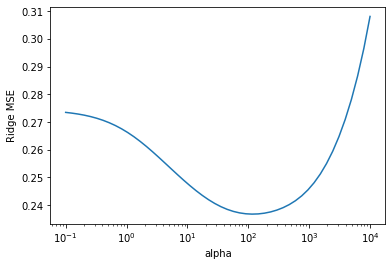

In [26]:
plt.plot(alphas, results)
plt.gca().set_xscale('log')
plt.gca().set_xlabel('alpha')
plt.gca().set_ylabel('Ridge MSE');

In [ ]:
f = get_filename('wave2vec2.feature_extractor.conv_layers.3', 'none', 'mean')
print(f)
np.load(f)['arr_0'].shape

wave2vec2.feature_extractor.conv_layers.3__none__mean.npz


(2641, 512)

In [ ]:
f = get_filename('wave2vec2.transformer.layers.10', 'none', 'mean')
print(f)
np.load(f)['arr_0'].shape

wave2vec2.transformer.layers.10__none__mean.npz


(2641, 768)

In [35]:
from IPython.display import HTML, display

pd.set_option('display.float_format', '{:.3f}'.format)

def format_vertical_headers(df):
    """Display a dataframe with vertical column headers"""
    styles = [dict(selector="th", props=[('width', '40px')]),
              dict(selector="th.col_heading",
                   props=[("writing-mode", "vertical-rl"),
                          ('transform', 'rotateZ(180deg)'), 
                          ('height', '290px'),
                          ('vertical-align', 'top')])]
    return (df.round(3).style.set_table_styles(styles))

format_vertical_headers(results)

,none__mean_std,none__max,none__mean,random_projection__mean_std,random_projection__max,random_projection__mean,random_rnn__mean_std,random_rnn__last,random_rnn__max,random_rnn__mean,random_esn__mean_std,random_esn__last,random_esn__max,random_esn__mean,random_biGRU_512__mean,random_biLSTM_512__mean,random_biGRU_try2_512__mean,random_biLSTM_try2_512__mean
wave2vec2.feature_extractor.conv_layers.3,0.372682,0.418258,0.392060,0.427311,0.410893,0.424811,0.382758,0.789094,0.452899,0.412750,0.369910,0.852557,0.491786,0.421207,0.399733,nan,nan,nan
wave2vec2.feature_extractor.conv_layers.5,0.335365,0.422317,0.349080,0.348375,0.362237,0.364850,0.332817,0.753044,0.384331,0.352826,0.337834,0.803694,0.463314,0.394679,nan,nan,nan,nan
wave2vec2.feature_extractor.conv_layers.6,0.316358,0.414847,0.370762,0.352313,0.329919,0.394742,0.324412,0.740715,0.415992,0.382969,0.343803,0.814144,0.486577,0.376861,nan,nan,nan,nan
wave2vec2.transformer.layers.0,0.283368,0.355321,0.250647,0.308239,0.285937,0.268514,0.267469,0.541493,0.346459,0.269494,0.279010,0.615287,0.436034,0.265138,0.252984,0.253195,0.255820,0.256999
wave2vec2.transformer.layers.1,0.260379,0.319049,0.228526,0.279327,0.272578,0.257324,0.260067,0.423876,0.336460,0.239265,0.256290,0.517695,0.379067,0.237188,0.234590,0.232838,0.231774,0.234518
wave2vec2.transformer.layers.2,0.290564,0.340610,0.252189,0.310167,0.295284,0.286377,0.261802,0.357895,0.335835,0.249198,0.260031,0.461288,0.365335,0.253330,0.251244,0.252329,0.256078,0.251075
wave2vec2.transformer.layers.4,0.276949,0.382982,0.259631,0.310971,0.309951,0.299090,0.284691,0.396283,0.366651,0.262969,0.289271,0.483063,0.410059,0.258321,0.256986,0.259485,0.262628,0.264758
wave2vec2.transformer.layers.6,0.327596,0.434856,0.303547,0.339847,0.340750,0.346588,0.326283,0.453688,0.424071,0.309083,0.328329,0.554344,0.462166,0.321778,nan,nan,nan,nan
wave2vec2.transformer.layers.8,0.370450,0.452041,0.338634,0.395469,0.387590,0.378177,0.356378,0.493026,0.433184,0.351219,0.362828,0.550018,0.482102,0.352540,nan,nan,nan,nan
wave2vec2.transformer.layers.10,0.394090,0.539402,0.389053,0.424378,0.509308,0.392563,0.424059,0.459578,0.488919,0.434785,0.429447,0.552357,0.511875,0.443218,nan,nan,nan,nan


In [34]:
results.to_csv('1.csv')